# A kernel modeled after Siraj's recent video
Siraj probably needs no introduction. He recently did a [video on this earthquake competition](https://www.youtube.com/watch?v=TffGdSsWKlA), which is informative to data science noobs like me. I like the step by step approach. Watch that video if you want to see how to construct a kernel from scratch, but do note that it runs on Google's Colab framework.

Following Siraj's step by step approach, I'm following my own steps in constructing this kernel in a Kaggle environment. I added the submission steps, since I want to use this kernel as a template with other models instead of the LSTM. 

## My Steps
1. Install the Dependencies
1. Import the Dataset
1. Exploratory Data Analysis
1. Feature Engineering
1. Implement Model
1. Evaluate Model
1. Finalise Submission
1. Future Directions

## Install the Dependencies
Fortunately, the kaggle dependencies are already installed. I opted to install model specific dependencies in that code block, since the code is easier to modify in terms of swopping out models. It's also easier to see what you have imported and what is still missing in this way.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Installing dependencies
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#data visualization
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


## Import the Dataset
Since we aren't using the Google Colab framework, we can import the dataset directly. 

In [2]:
# Extract training data into a dataframe for further manipulation
train = pd.read_csv('../input/train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

# Print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


## Exploratory Data Analysis
For this, we just visualise the data and see what we can deduce from the graphs.

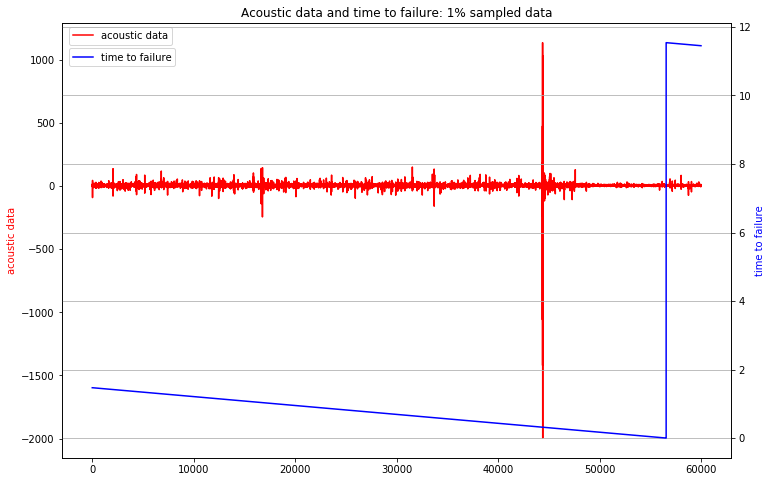

In [3]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

## Feature Engineering
Adding statistical features. Siraj adds a few of the most common ones, plus he has a handy description of most of these in his [notebook on github](https://github.com/llSourcell/Kaggle_Earthquake_challenge/blob/master/Earthquake_Challenge.ipynb). 

This kernel, called [Earthquakes FE More Features and Samples](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples), contains more features. There are also links to more ideas if you want to engineer additional features. For this kernel, I'm sticking to Siraj's basics.

In [4]:
# let's create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

For this, note how the chunks are used to iterate through this fairly large dataset. Each chunk is processed, and the results are appended to the *X_train* and *y_train* dataframes. This is somewhat different from some of the other kernels that I used, where all the chunks weren't iterated through and the training data was just limited.

In [5]:
train = pd.read_csv('../input/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    

# Let's see what we have done
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


## Implement Model
In this case, I am implementing an [LSTM Model](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/). 

Siraj implemented an SVR and a CatBoost model. Since I want to use this as a template, I didn't replicate the SVR or CatBoost model here, but decided to implement a different one. If you are interested in the others, have a look at Siraj's work. The SVR seems to get a better score than the CatBoost model.

I ran into some trouble with the shapes of the training and testing data. The LSTM model itself is not that important to me here, since I only want to use this kernel as a template for other models.

I've removed the parts where I split into training and test sets, since this is time series data and it's not really necessary. 



In [12]:
# LSTM Model
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Reshape to correct dimensions
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0],X_train_scaled.shape[1],1)

# Model
model = Sequential()
model.add(LSTM(50,  input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(X_train_scaled, 
                    y_train, 
                    epochs=15,
                    batch_size=64,
                    verbose=0)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


"plt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='test')\nplt.legend()\nplt.show()"

## Evaluate Model
Do the hyper parameter tuning or other means of evaluating the model here.

In [13]:
# Evaluate model
from sklearn.metrics import mean_absolute_error
    
y_pred = model.predict(X_train_scaled)
mae = mean_absolute_error(y_train, y_pred)
print('%.5f' % mae)



2.16595


## Finalise Submission
Siraj doesn't provide the code for this. I had to glean this from other kernels. So far, we have only seen training data. We haven't dealt with test data, so that needs to be done as well.

In [8]:
# submission format
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

# prepare test data
for seg_id in submission.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test = scaler.transform(X_test)

### Generate predictions for the submission.

The prediction here is from the LSTM model. You would have to reinitialise the SVR with the hyper parameter tuning values and get your prediction from that if you want to submit SVR model data.

In [10]:
# model of choice here
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_hat = model.predict(X_test)

In [11]:
# write submission file
submission['time_to_failure'] = y_hat
submission.to_csv('submission.csv')

## Future Directions
1. Recurrent Networks. See my kernel, [RNN Starter Kernel](https://www.kaggle.com/devilears/rnn-starter-kernel-with-notebook), for starter code.
1. Genetic Algorithms.
1. [Ordinary Differential Equation Network](https://towardsdatascience.com/paper-summary-neural-ordinary-differential-equations-37c4e52df128). See also [Neural Ordinary Differential Equations](https://paperswithcode.com/paper/neural-ordinary-differential-equations).